In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Data Preparation

## Import ASHRAE Global Thermal Comfort Database 2

In [240]:
# Read metadata and data from Github
df_meta = pd.read_csv("https://github.com/CenterForTheBuiltEnvironment/ashrae-db-II/raw/master/v2.1.0/db_metadata.csv")
df_measurements = pd.read_csv("https://github.com/CenterForTheBuiltEnvironment/ashrae-db-II/raw/master/v2.1.0/db_measurements_v2.1.0.csv.gz", low_memory=False)
# Merge metadata and measurement data by building_id
df_rawdata = df_measurements.merge(df_meta[['building_id', 'city', 'building_type', 'cooling_type', 'records', 'database']], on='building_id', how='left')
# Replace two outdoor temperature columns by a new column called t_out_combined
df_rawdata.loc[:, 't_out_combined'] = df_rawdata.loc[:, 't_out_isd'].fillna(df_rawdata.loc[:, 't_out'])
df_rawdata = df_rawdata.drop(columns=['t_out_isd', 't_out'])
print('Total buildings:', len(df_rawdata.building_id.unique()))
print('Total occupants:', len(df_rawdata))

Total buildings: 809
Total occupants: 109033


## Select concurrent Top, TSV, and Tout data

In [241]:
df_data_Top_TSV = df_rawdata.dropna(subset=['top', 'thermal_sensation', 't_out_combined'])
print(f'Buildings without missing data:', len(df_data_Top_TSV ['building_id'].unique()))
print(f'Buildings occupants without missing data:', len(df_data_Top_TSV ))

Buildings without missing data: 553
Buildings occupants without missing data: 38467


## Group data by building ID, with mean values

In [243]:
# Group by 'building_id' and calculate the mean for all these columns at once
df_data_mean = df_data_Top_TSV.groupby('building_id')[['t_out_combined', 'top', 'vel', 'set', 'thermal_sensation']].mean()
# Reset the index of df_data_mean to make 'building_id' a column again
df_data_mean.reset_index(inplace=True)
# Merge df_data_mean with the metadata
df_bldg = df_data_mean.merge(df_meta[['building_id', 'records', 'cooling_type', 'building_type', 'database']], on='building_id', how='left')
# Reset the building cooling type as string
df_bldg['cooling_type'] = df_bldg['cooling_type'].str.title()
df_bldg.head()

,building_id,t_out_combined,top,vel,set,thermal_sensation,records,cooling_type,building_type,database
0,1,15.296857,23.239679,0.092130,25.454225,0.627219,170,Mixed Mode,office,1.0
1,2,13.995833,22.283912,0.171084,23.616000,-0.072289,83,Air Conditioned,office,1.0
2,3,0.583480,23.178237,0.081647,23.694118,0.252941,85,Air Conditioned,office,1.0
3,4,19.280947,23.973630,0.155111,24.164706,0.103704,137,Mixed Mode,office,1.0
4,5,9.048210,22.095310,0.071927,22.271875,-0.063281,128,Air Conditioned,office,1.0


# First Stage of ACM II

## Estimate neutral temperature and 80% comfort zone for each building

In [244]:
def regression_op_a(data_bldg):
    """
    TSV = a * top + b
    Regressing Thermal Sensation Vote (TSV) against indoor operative temperature (top).    
    Use the regression model to derive the neutral temperature by letting TSV equals 0.
    The upper and lower limit of 80% comfort zone are derived by letting TSV equals +-0.85.
    """
    lm_result = smf.ols(formula='thermal_sensation ~ top', data=data_bldg).fit()
    slope = lm_result.params['top']
    intercept = lm_result.params['Intercept']
    # check whether the slope is significant
    if lm_result.pvalues['top'] < 0.05:
        a = slope
        b = intercept
        temp_n = -b / a
        temp_up = (0.85-b)/a
        temp_low = (-0.85-b)/a
        return [slope, intercept, temp_n, temp_up, temp_low]
    else:
        return [np.nan] * 5  # Return NaNs if the slope is not significant


In [245]:
df_bldg_1 = df_bldg.copy()
# Apply the function to each group of df_data_1 grouped by 'building_id'
grouped_results = df_data_Top_TSV .groupby('building_id').apply(regression_op_a)
# Convert the grouped results into a DataFrame with appropriate column names
results_df = pd.DataFrame(grouped_results.tolist(), index=grouped_results.index, columns=['slope', 'intercept', 'temp_n', 'temp_up', 'temp_low'])
# Merge the results back into df_bldg_1
df_bldg_1 = df_bldg_1.merge(results_df, left_on='building_id', right_index=True, how='left')

## Select NV office buildings that achieve significant models

In [246]:
# Get rid of all nan values in the temp_n column
df_bldg_1_sig = df_bldg_1[~df_bldg_1['temp_n'].isna()]
df_bldg_1_sig_NV = df_bldg_1_sig[df_bldg_1_sig['cooling_type'] == 'Naturally Ventilated'].copy()
df_bldg_1_sig_NV_office = df_bldg_1_sig_NV[df_bldg_1_sig_NV['building_type'] == 'office'].copy()
print("NV office buildings with significant models:", len(df_bldg_1_sig_NV_office))

NV office buildings with significant models: 51


## Remove unreasonable neutral temperature estimation resutls

In [247]:
# Plot t_out_combined and temp_n data points in df_bldg_1_sig_NV_office
# sns.scatterplot(data=df_bldg_1_sig_NV_office, x='t_out_combined', y='temp_n')
# Identifiy outliers of temp_n
outliers = df_bldg_1_sig_NV_office[(df_bldg_1_sig_NV_office['temp_n'] < 0)]
# remove the outliers
df_ACM = df_bldg_1_sig_NV_office.drop(outliers.index)
outliers

,building_id,t_out_combined,top,vel,set,thermal_sensation,records,cooling_type,building_type,database,slope,intercept,temp_n,temp_up,temp_low
154,155,27.579167,26.860208,NaN,NaN,-0.25,20,Naturally Ventilated,office,1.0,-0.009295,-0.000346,-0.03723,-91.488518,91.414058


# Second Stage of ACM II

## Conduct weighted linear regression

In [248]:
def weighted_reg(x, y, weights):
    X = sm.add_constant(x)
    model = sm.WLS(y, X, weights=weights).fit()
    intercept, slope = model.params
    print('p value: {:.3f}'.format(model.pvalues[1]))
    print('MSE: {:.1f}'.format(np.mean(model.resid ** 2)))
    print('RMSE: {:.1f}'.format(np.sqrt(np.mean(model.resid ** 2))))
    print(model.summary())
    return intercept, slope

In [249]:
intercept, slope = weighted_reg(df_ACM['t_out_combined'], df_ACM['temp_n'], df_ACM['records'])
# print the fitted line slope and intercept
print("******************************************************************************")
print('ACM regression line slope: {:.2f}'.format(slope))
print('ACM regression line intercept: {:.2f}'.format(intercept))
# calculate the mean range of 80% comfort zone
range = df_ACM['temp_up'].mean() - df_ACM['temp_low'].mean()
print('ACM 80% comfort zone: {:.2f}'.format(range))

p value: 0.000
MSE: 3.6
RMSE: 1.9
                            WLS Regression Results                            
Dep. Variable:                 temp_n   R-squared:                       0.502
Model:                            WLS   Adj. R-squared:                  0.491
Method:                 Least Squares   F-statistic:                     48.35
Date:                Fri, 01 Mar 2024   Prob (F-statistic):           8.67e-09
Time:                        22:44:44   Log-Likelihood:                -102.43
No. Observations:                  50   AIC:                             208.9
Df Residuals:                      48   BIC:                             212.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const     

## Plot resulting ACM II

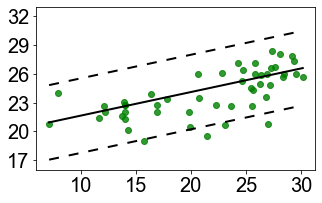

In [250]:
# sort the data points by t_out_combined
t_out = np.array(df_ACM['t_out_combined'])
t_out = t_out[np.argsort(t_out)]
middle_line = slope * t_out + intercept
up_line = slope * t_out + intercept + range/2
low_line = slope * t_out + intercept - range/2

middle_ASHRAE = 0.31 * t_out + 17.8
up_ASHRAE = 0.31 * t_out + 17.8 + 3.5
low_ASHRAE = 0.31 * t_out + 17.8 - 3.5

# plot data points
plt.figure(figsize=(5, 3))
sns.regplot(x='t_out_combined', y='temp_n', data=df_ACM, fit_reg=False, scatter_kws={'color': 'green'})
plt.plot(t_out, middle_line, color='black', linewidth=2)
plt.plot(t_out, up_line, color='black', linewidth=2, linestyle='--', dashes=(5, 5))
plt.plot(t_out, low_line, color='black', linewidth=2, linestyle='--', dashes=(5, 5))

# # plt.plot(t_out, middle_ASHRAE, color='grey', linewidth=1)
# plt.plot(t_out, up_ASHRAE, color='grey', linewidth=1, linestyle='--', dashes=(5, 5))
# plt.plot(t_out, low_ASHRAE, color='grey', linewidth=1, linestyle='--', dashes=(5, 5))

plt.xlabel('', fontsize=20)
plt.ylabel('', fontsize=20)
plt.xticks(np.arange(5, 33, 5), fontsize=20)
plt.yticks(np.arange(17, 33, 3), fontsize=20)
plt.ylim(16, 33)
plt.grid(False)
plt.rcParams['font.family'] = 'Arial'
# show grey and black color legend
plt.plot([], [], color='grey', linewidth=1, linestyle='--', label='ASHRAE ACM')
plt.plot([], [], color='black', linewidth=2, linestyle='--', label='ACM II')
# show legend on top of the graph
# plt.legend(loc='upper center', bbox_to_anchor=(0.4, 1.3), ncol=2, fontsize=20)
plt.savefig('figs/fig_ACM_Top.pdf', format='pdf', bbox_inches='tight')

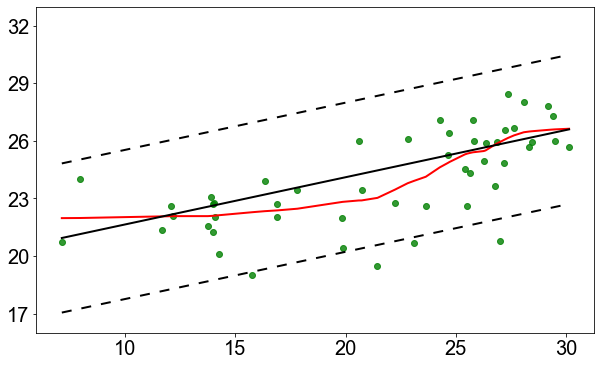

In [251]:
# sort the data points by t_out_combined
t_out = np.array(df_ACM['t_out_combined'])
t_out = t_out[np.argsort(t_out)]
middle_line = slope * t_out + intercept
up_line = slope * t_out + intercept + range/2
low_line = slope * t_out + intercept - range/2

middle_ASHRAE = 0.31 * t_out + 17.8
up_ASHRAE = 0.31 * t_out + 17.8 + 3.5
low_ASHRAE = 0.31 * t_out + 17.8 - 3.5

lowess = sm.nonparametric.lowess(df_ACM['temp_n'], df_ACM['t_out_combined'], frac=0.4)
# plot data points
plt.figure(figsize=(10, 6))
sns.regplot(x='t_out_combined', y='temp_n', data=df_ACM, fit_reg=False, scatter_kws={'color': 'green'})
plt.plot(lowess[:, 0], lowess[:, 1], color='red', linewidth=2)
plt.plot(t_out, middle_line, color='black', linewidth=2)
plt.plot(t_out, up_line, color='black', linewidth=2, linestyle='--', dashes=(5, 5))
plt.plot(t_out, low_line, color='black', linewidth=2, linestyle='--', dashes=(5, 5))

plt.xlabel('', fontsize=20)
plt.ylabel('', fontsize=20)
plt.xticks(np.arange(5, 33, 5), fontsize=20)
plt.yticks(np.arange(17, 33, 3), fontsize=20)
plt.ylim(16, 33)
plt.grid(False)
plt.rcParams['font.family'] = 'Arial'
# show grey and black color legend
plt.plot([], [], color='grey', linewidth=1, linestyle='--', label='ASHRAE ACM')
plt.plot([], [], color='black', linewidth=2, linestyle='--', label='ACM II')
# show legend on top of the graph
# plt.legend(loc='upper center', bbox_to_anchor=(0.4, 1.3), ncol=2, fontsize=20)
plt.savefig('figs/fig_ACM_fix.pdf', format='pdf', bbox_inches='tight')

# Evidence 1:

In [252]:
def accuracy_mean(slope, intercept, range, df, temp):
    """
    Calculate the accuracy of a ACM model based on the df, using a calssification method.
    If the temp is in the comfort zone and TSV is in +-0.85, then it is classified as 1, or
    If the temp is out of the comfort zone and TSV is out of the 0.85, then it is classified as 1, or
    If the temp is below the comfort zone and TSV is smaller than 0.85, then it is classified as 1, otherwies 0.
    Count the percentage of 1 over total records in df as the prediction accuracy.
    """
    df.count = np.where(
        # Case 1: Comfortable when within range
        ((df.thermal_sensation >= -0.85) & 
        (df.thermal_sensation <= 0.85) & 
        (df[temp] >= df.t_out_combined * slope + intercept - range/2) & 
        (df[temp] <= df.t_out_combined * slope + intercept + range/2)) |
        # Case 2: Uncomfortable when out of range
        ((df.thermal_sensation < -0.85) | 
        (df.thermal_sensation > 0.85)) & 
        ((df[temp] < df.t_out_combined * slope + intercept - range/2) | 
        (df[temp] > df.t_out_combined * slope + intercept + range/2)),
        1,  # Accurate prediction
        0)   # Inaccurate prediction
    percent = len(df[df.count == 1])/len(df)
    return percent

def accuracy_individual(slope, intercept, range, df, temp):
    """
    Calculate the accuracy of a ACM model based on the df, using a calssification method.
    If the temp is in the comfort zone and TSV is in +-0.85, then it is classified as 1, or
    If the temp is out of the comfort zone and TSV is out of the 0.85, then it is classified as 1, or
    If the temp is below the comfort zone and TSV is smaller than 0.85, then it is classified as 1, otherwies 0.
    Count the percentage of 1 over total records in df as the prediction accuracy.
    """
    df.count = np.where(
        # Case 1: Comfortable when within range
        ((df.thermal_sensation >= -1.5) & 
        (df.thermal_sensation <= 1.5) & 
        (df[temp] >= df.t_out_combined * slope + intercept - range/2) & 
        (df[temp] <= df.t_out_combined * slope + intercept + range/2)) |
        # Case 2: Uncomfortable when out of range
        ((df.thermal_sensation < -1.5) | 
        (df.thermal_sensation > 1.5)) & 
        ((df[temp] < df.t_out_combined * slope + intercept - range/2) | 
        (df[temp] > df.t_out_combined * slope + intercept + range/2)),
        1,  # Accurate prediction
        0)   # Inaccurate prediction
    percent = len(df[df.count == 1])/len(df)
    return percent

def accuracy_accept(slope, intercept, range, df, temp):
    """
    Calculate the accuracy of a ACM model based on the df, using a calssification method.
    If the temp is in the comfort zone and TSV is in +-1.5, then it is classified as 1, or
    If the temp is out of the comfort zone and TSV is out of the 0.85, then it is classified as 1, or
    If the temp is below the comfort zone and TSV is smaller than 0.85, then it is classified as 1, otherwies 0.
    Count the percentage of 1 over total records in df as the prediction accuracy.
    """
    df.count = np.where(
        # Case 1: Comfortable when within range
        ((df.thermal_acceptability == 'acceptable') & 
        (df[temp] >= df.t_out_combined * slope + intercept - range/2) & 
        (df[temp] <= df.t_out_combined * slope + intercept + range/2)) |
        # Case 2: Uncomfortable when out of range
        (df.thermal_acceptability == 'unacceptable') & 
        ((df[temp] < df.t_out_combined * slope + intercept - range/2) | 
         (df[temp] > df.t_out_combined * slope + intercept + range/2)),
        1,  # Accurate prediction
        0)   # Inaccurate prediction
    percent = len(df[df.count == 1])/len(df)
    return percent

## Prepare data for prediction accuracy

In [253]:
df_data_Top_TA = df_rawdata.dropna(subset=['top', 'thermal_acceptability', 't_out_combined'])

In [255]:
# Reset the building cooling type as string, ensuring direct modification of the DataFrame
df_data_Top_TA = df_data_Top_TA.copy()
df_data_Top_TA['cooling_type'] = df_data_Top_TA['cooling_type'].str.title()

# Filter for office buildings with naturally ventilated cooling
df_bldg_1_NV = df_bldg_1[df_bldg_1['cooling_type'] == 'Naturally Ventilated']
df_data_1_NV = df_data_Top_TA[df_data_Top_TA['cooling_type'] == 'Naturally Ventilated']
print(f'NV buildings without missing data:', len(df_bldg_1_NV))
print(f'NV building occupants without missing data:', len(df_data_1_NV))

# Filter for office buildings with naturally ventilated cooling
df_bldg_1_NV_office = df_bldg_1_NV[df_bldg_1_NV['building_type'] == 'office']
df_data_1_NV_office = df_data_1_NV[df_data_1_NV['building_type'] == 'office']
print(f'NV office buildings without missing data:', len(df_bldg_1_NV_office))
print(f'NV office building occupants without missing data:', len(df_data_1_NV_office))

NV buildings without missing data: 216
NV building occupants without missing data: 7025
NV office buildings without missing data: 67
NV office building occupants without missing data: 6281


## ASHRAE ACM prediction accuracy

In [256]:
slope = 0.31
intercept = 17.8
range = 7

result = 100 * accuracy_individual(slope, intercept, range, df_data_1_NV, 'top')
print('Individual TSV prediction accraucy, NV building: {:.0f} %'.format(result))
result = 100 * accuracy_individual(slope, intercept, range, df_data_1_NV_office, 'top')
print('Individual TSV prediction accraucy, NV office building: {:.0f} %'.format(result))

result = 100 * accuracy_mean(slope, intercept, range, df_bldg_1_NV, 'top')
print('Mean TSV prediction accraucy, NV building: {:.0f} %'.format(result))
result = 100 * accuracy_mean(slope, intercept, range, df_bldg_1_NV_office, 'top')
print('Mean TSV prediction accraucy, NV office building: {:.0f} %'.format(result))

result = 100 * accuracy_accept(slope, intercept, range, df_data_1_NV, 'top')
print('Individual acceptablility prediction accraucy, NV building: {:.0f} %'.format(result))
result = 100 * accuracy_accept(slope, intercept, range, df_data_1_NV_office, 'top')
print('Individual acceptablilityprediction accraucy, NV office building: {:.0f} %'.format(result))


Individual TSV prediction accraucy, NV building: 66 %
Individual TSV prediction accraucy, NV office building: 68 %
Mean TSV prediction accraucy, NV building: 56 %
Mean TSV prediction accraucy, NV office building: 70 %
Individual acceptablility prediction accraucy, NV building: 50 %
Individual acceptablilityprediction accraucy, NV office building: 49 %


## ACM II prediction accuracy

In [257]:
slope = 0.25
intercept = 19.2
range = 7.8

result = 100 * accuracy_individual(slope, intercept, range, df_data_1_NV, 'top')
print('All TSV prediction accraucy, NV building: {:.0f} %'.format(result))
result = 100 * accuracy_individual(slope, intercept, range, df_data_1_NV_office, 'top')
print('All TSV prediction accraucy, NV office building: {:.0f} %'.format(result))

result = 100 * accuracy_mean(slope, intercept, range, df_bldg_1_NV, 'top')
print('Mean TSV prediction accraucy, NV building: {:.0f} %'.format(result))
result = 100 * accuracy_mean(slope, intercept, range, df_bldg_1_NV_office, 'top')
print('Mean TSV prediction accraucy, NV office building: {:.0f} %'.format(result))

result = 100 * accuracy_accept(slope, intercept, range, df_data_1_NV, 'top')
print('Individual acceptablility prediction accraucy, NV building: {:.0f} %'.format(result))
result = 100 * accuracy_accept(slope, intercept, range, df_data_1_NV_office, 'top')
print('Individual acceptablilityprediction accraucy, NV office building: {:.0f} %'.format(result))

All TSV prediction accraucy, NV building: 67 %
All TSV prediction accraucy, NV office building: 69 %
Mean TSV prediction accraucy, NV building: 55 %
Mean TSV prediction accraucy, NV office building: 66 %
Individual acceptablility prediction accraucy, NV building: 51 %
Individual acceptablilityprediction accraucy, NV office building: 50 %


## Optimize slope, intercept and range

In [202]:
slope = 0
low = 20
up = 25
intercept = (up + low) / 2
range = up - low

result = 100 * accuracy_individual(slope, intercept, range, df_data_1_NV, 'top')
print('All TSV prediction accraucy, NV building: {:.0f} %'.format(result))
result = 100 * accuracy_individual(slope, intercept, range, df_data_1_NV_office, 'top')
print('All TSV prediction accraucy, NV office building: {:.0f} %'.format(result))

result = 100 * accuracy_mean(slope, intercept, range, df_bldg_1_NV, 'top')
print('Mean TSV prediction accraucy, NV building: {:.0f} %'.format(result))
result = 100 * accuracy_mean(slope, intercept, range, df_bldg_1_NV_office, 'top')
print('Mean TSV prediction accraucy, NV office building: {:.0f} %'.format(result))

result = 100 * accuracy_accept(slope, intercept, range, df_data_1_NV, 'top')
print('Individual acceptablility prediction accraucy, NV building: {:.0f} %'.format(result))
result = 100 * accuracy_accept(slope, intercept, range, df_data_1_NV_office, 'top')
print('Individual acceptablilityprediction accraucy, NV office building: {:.0f} %'.format(result))

All TSV prediction accraucy, NV building: 39 %
All TSV prediction accraucy, NV office building: 42 %
Mean TSV prediction accraucy, NV building: 36 %
Mean TSV prediction accraucy, NV office building: 52 %
Individual acceptablility prediction accraucy, NV building: 57 %
Individual acceptablilityprediction accraucy, NV office building: 62 %


<AxesSubplot:xlabel='top', ylabel='Count'>

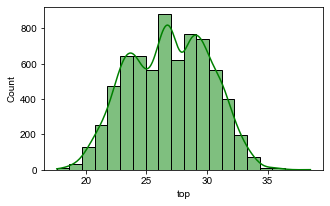

In [127]:
# plot the quantile distribution of top in df_data_1_NV
plt.figure(figsize=(5, 3))
sns.histplot(df_data_1_NV['top'], kde=True, bins=20, color='green')


<AxesSubplot:xlabel='thermal_acceptability', ylabel='Count'>

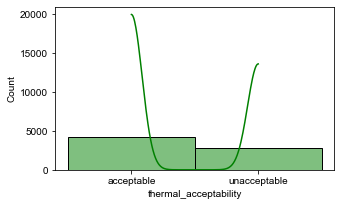

In [128]:
# plot the quantile distribution of top in df_data_1_NV
plt.figure(figsize=(5, 3))
sns.histplot(df_data_1_NV['thermal_acceptability'], kde=True, bins=20, color='green')

In [19]:
# create a list to store the results
results = []
slope = 0
for slope in np.arange(0.2, 0.4, 0.1):
    for intercept in np.arange(20, 25, 0.1):
        for range in np.arange(0, 15, 0.1):
            accuracy_NV = accuracy(slope, intercept, range, df_data_1_NV, 'top')
            accuracy_NV_office = accuracy(slope, intercept, range, df_data_1_NV_office, 'top')
            accuracy_NV_mean = accuracy(slope, intercept, range, df_bldg_1_NV, 'top')
            accuracy_NV_office_mean = accuracy(slope, intercept, range, df_bldg_1_NV_office, 'top')
            results.append({'Slope': slope, 
                            'Intercept': intercept, 
                            'Range': range, 
                            'Accuracy_NV': accuracy_NV,
                            'Accuracy_NV_office': accuracy_NV_office,
                            'Accuracy_NV_mean': accuracy_NV_mean,
                            'Accuracy_NV_office_mean': accuracy_NV_office_mean})
results_df = pd.DataFrame(results)

In [22]:
for i in ['Accuracy_NV','Accuracy_NV_office','Accuracy_NV_mean','Accuracy_NV_office_mean']:
    print(results_df.nlargest(1, i)[['Slope', 'Intercept', 'Range', i]].to_string(index=False))

 Slope  Intercept  Range  Accuracy_NV
     0       24.1    0.3     0.597816
 Slope  Intercept  Range  Accuracy_NV_office
     0       20.7    8.5            0.600978
 Slope  Intercept  Range  Accuracy_NV_mean
     0       24.9   14.9          0.703704
 Slope  Intercept  Range  Accuracy_NV_office_mean
     0       22.8   14.8                 0.776119


# Evidence 2:

## Select concurrent SET, TSV, and Tout data

In [258]:
df_data_2 = df_rawdata.dropna(subset=['set', 'thermal_sensation', 't_out_combined'])
print(f'Buildings without missing data:', len(df_data_2['building_id'].unique()))
print(f'Buildings occupants without missing data:', len(df_data_2))

Buildings without missing data: 570
Buildings occupants without missing data: 34313


In [259]:
def regression_SET_a(data_bldg):
    """
    TSV = a * set + b
    Regressing Thermal Sensation Vote (TSV) against Standard Effective Temperature (set).    
    Use the regression model to derive the neutral temperature by letting TSV equals 0.
    The upper and lower limit of 80% comfort zone are derived by letting TSV equals +-0.85.
    """
    lm_result = smf.ols(formula='thermal_sensation ~ set', data=data_bldg).fit()
    slope = lm_result.params['set']
    intercept = lm_result.params['Intercept']
    # check whether the slope is significant
    if lm_result.pvalues['set'] < 0.05:
        a = slope
        b = intercept
        temp_n = -b / a
        temp_up = (0.85-b)/a
        temp_low = (-0.85-b)/a
        return [slope, intercept, temp_n, temp_up, temp_low]
    else:
        return [np.nan] * 5  # Return NaNs if the slope is not significant

In [260]:
df_bldg_2 = df_bldg.copy()
# Apply the function to each group of df_data_2 grouped by 'building_id'
grouped_results = df_data_2.groupby('building_id').apply(regression_SET_a)
# Convert the grouped results into a DataFrame with appropriate column names
results_df = pd.DataFrame(grouped_results.tolist(), index=grouped_results.index, columns=['slope', 'intercept', 'temp_n', 'temp_up', 'temp_low'])
# Merge the results back into df_bldg_2
df_bldg_2 = df_bldg_2.merge(results_df, left_on='building_id', right_index=True, how='left')

In [261]:
# Reset the building cooling type as string, ensuring direct modification of the DataFrame
df_data_2 = df_data_2.copy()
df_data_2['cooling_type'] = df_data_2['cooling_type'].str.title()

# Filter for office buildings with naturally ventilated cooling
df_bldg_2_NV = df_bldg_2[df_bldg_2['cooling_type'] == 'Naturally Ventilated']
df_data_2_NV = df_data_2[df_data_2['cooling_type'] == 'Naturally Ventilated']
print(f'NV buildings without missing data:', len(df_bldg_2_NV))
print(f'NV building occupants without missing data:', len(df_data_2_NV))

# Filter for office buildings with naturally ventilated cooling
df_bldg_2_NV_office = df_bldg_2_NV[df_bldg_2_NV['building_type'] == 'office']
df_data_2_NV_office = df_data_2_NV[df_data_2_NV['building_type'] == 'office']
print(f'NV office buildings without missing data:', len(df_bldg_2_NV_office))
print(f'NV office building occupants without missing data:', len(df_data_2_NV_office))

NV buildings without missing data: 216
NV building occupants without missing data: 15394
NV office buildings without missing data: 67
NV office building occupants without missing data: 8638


## SET ACM for NV office buildings

In [262]:
# Get rid of all nan values in the temp_n column
df_bldg_2_sig = df_bldg_2[~df_bldg_2['temp_n'].isna()]
df_bldg_2_sig_NV = df_bldg_2_sig[df_bldg_2_sig['cooling_type'] == 'Naturally Ventilated'].copy()
df_bldg_2_sig_NV_office = df_bldg_2_sig_NV[df_bldg_2_sig_NV['building_type'] == 'office'].copy()
print("NV office buildings with significant models:", len(df_bldg_2_sig_NV_office))

NV office buildings with significant models: 35


In [263]:
# Plot t_out_combined and temp_n data points in df_bldg_2_sig_NV_office
# sns.scatterplot(data=df_bldg_2_sig_NV_office, x='t_out_combined', y='temp_n')
# Identifiy outliers of temp_n
outliers = df_bldg_2_sig_NV_office[(df_bldg_2_sig_NV_office['temp_n'] < 15) | (df_bldg_2_sig_NV_office['temp_n'] > 30)]
# remove the outliers
df_ACM_SET = df_bldg_2_sig_NV_office.drop(outliers.index)
outliers

,building_id,t_out_combined,top,vel,set,thermal_sensation,records,cooling_type,building_type,database,slope,intercept,temp_n,temp_up,temp_low
143,144,27.029000,31.679695,0.448404,27.991176,0.988636,176,Naturally Ventilated,office,1.0,0.060393,-0.739503,12.244753,26.319134,-1.829628
166,173,20.600851,24.590566,0.090991,27.525649,-0.191489,470,Naturally Ventilated,office,1.0,0.047435,-1.451783,30.605736,48.524994,12.686477
169,176,13.992661,18.732617,0.153595,23.241102,-0.763209,513,Naturally Ventilated,office,1.0,0.065926,-2.032200,30.825328,43.718512,17.932144


In [305]:
intercept, slope = weighted_reg(df_ACM_SET['t_out_combined'], df_ACM_SET['temp_n'], df_ACM_SET['records'])
# print the fitted line slope and intercept
print("******************************************************************************")
print('ACM regression line slope: {:.2f}'.format(slope))
print('ACM regression line intercept: {:.2f}'.format(intercept))
# calculate the mean range of 80% comfort zone
range = df_ACM_SET['temp_up'].mean() - df_ACM_SET['temp_low'].mean()
print('ACM 80% comfort zone: {:.2f}'.format(range))

p value: 0.471
MSE: 7.5
RMSE: 2.7
                            WLS Regression Results                            
Dep. Variable:                 temp_n   R-squared:                       0.017
Model:                            WLS   Adj. R-squared:                 -0.015
Method:                 Least Squares   F-statistic:                    0.5340
Date:                Fri, 01 Mar 2024   Prob (F-statistic):              0.471
Time:                        23:00:51   Log-Likelihood:                -87.392
No. Observations:                  32   AIC:                             178.8
Df Residuals:                      30   BIC:                             181.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const     

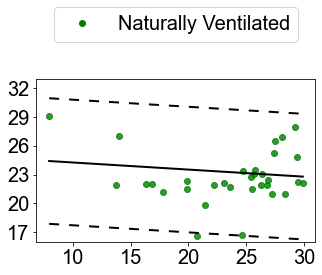

In [306]:
# sort the data points by t_out_combined
t_out = np.array(df_ACM_SET['t_out_combined'])
t_out = t_out[np.argsort(t_out)]
middle_line = slope * t_out + intercept
up_line = slope * t_out + intercept + range/2
low_line = slope * t_out + intercept - range/2

# plot data points
plt.figure(figsize=(5, 3))
sns.regplot(x='t_out_combined', y='temp_n', data=df_ACM_SET, fit_reg=False, scatter_kws={'color': 'green'})
plt.plot(t_out, middle_line, color='black', linewidth=2)
plt.plot(t_out, up_line, color='black', linewidth=2, linestyle='--', dashes=(5, 5))
plt.plot(t_out, low_line, color='black', linewidth=2, linestyle='--', dashes=(5, 5))

plt.xlabel('', fontsize=20)
plt.ylabel('', fontsize=20)
plt.xticks(np.arange(5, 33, 5), fontsize=20)
plt.yticks(np.arange(17, 33, 3), fontsize=20)
plt.ylim(16, 33)
plt.grid(False)
plt.rcParams['font.family'] ='Arial'
# show legend
plt.plot([], [], 'o', color='green', label='Naturally Ventilated')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.5), ncol=2, fontsize=20)
plt.savefig('figs/fig_ACM_SET.pdf', format='pdf', bbox_inches='tight')

In [307]:
df_data_SET_TA = df_rawdata.dropna(subset=['set', 'thermal_acceptability', 't_out_combined'])
print(f'Buildings without missing data:', len(df_data_SET_TA['building_id'].unique()))
print(f'Buildings occupants without missing data:', len(df_data_SET_TA))

Buildings without missing data: 409
Buildings occupants without missing data: 12334


In [308]:
# Reset the building cooling type as string, ensuring direct modification of the DataFrame
df_data_SET_TA = df_data_SET_TA.copy()
df_data_SET_TA['cooling_type'] = df_data_SET_TA['cooling_type'].str.title()

# Filter for office buildings with naturally ventilated cooling
df_data_SET_TA_NV = df_data_SET_TA[df_data_SET_TA['cooling_type'] == 'Naturally Ventilated']
print(f'NV building occupants without missing data:', len(df_data_SET_TA_NV))

# Filter for office buildings with naturally ventilated cooling
df_data_SET_TA_NV_office = df_data_SET_TA_NV[df_data_SET_TA_NV['building_type'] == 'office']
print(f'NV office building occupants without missing data:', len(df_data_SET_TA_NV_office))

NV building occupants without missing data: 3141
NV office building occupants without missing data: 1593


In [309]:
range

13.092252755620233

In [310]:
result = 100 * accuracy_individual(slope, intercept, range, df_data_2_NV, 'set')
print('Individual TSV prediction accraucy, NV building: {:.0f} %'.format(result))
result = 100 * accuracy_individual(slope, intercept, range, df_data_2_NV_office, 'set')
print('Individual TSV prediction accraucy, NV office building: {:.0f} %'.format(result))

result = 100 * accuracy_mean(slope, intercept, range, df_bldg_2_NV, 'set')
print('Mean TSV prediction accraucy, NV building: {:.0f} %'.format(result))
result = 100 * accuracy_mean(slope, intercept, range, df_bldg_2_NV_office, 'set')
print('Mean TSV prediction accraucy, NV office building: {:.0f} %'.format(result))

result = 100 * accuracy_accept(slope, intercept, range, df_data_SET_TA_NV, 'set')
print('Individual acceptablility prediction accraucy, NV building: {:.0f} %'.format(result))
result = 100 * accuracy_accept(slope, intercept, range, df_data_SET_TA_NV_office, 'set')
print('Individual acceptablilityprediction accraucy, NV office building: {:.0f} %'.format(result))

Individual TSV prediction accraucy, NV building: 72 %
Individual TSV prediction accraucy, NV office building: 74 %
Mean TSV prediction accraucy, NV building: 54 %
Mean TSV prediction accraucy, NV office building: 58 %
Individual acceptablility prediction accraucy, NV building: 72 %
Individual acceptablilityprediction accraucy, NV office building: 72 %


## SET ACM for AC office buildings

In [311]:
# Reset the building cooling type as string, ensuring direct modification of the DataFrame
df_data_2 = df_data_2.copy()
df_data_2['cooling_type'] = df_data_2['cooling_type'].str.title()

# Filter for office buildings with naturally ventilated cooling
df_bldg_2_AC = df_bldg_2[df_bldg_2['cooling_type'] == 'Air Conditioned']
df_data_2_AC = df_data_2[df_data_2['cooling_type'] == 'Air Conditioned']
print(f'AC buildings without missing data:', len(df_bldg_2_AC))
print(f'AC building occupants without missing data:', len(df_data_2_AC))

# Filter for office buildings with naturally ventilated cooling
df_bldg_2_AC_office = df_bldg_2_AC[df_bldg_2_AC['building_type'] == 'office']
df_data_2_AC_office = df_data_2_AC[df_data_2_AC['building_type'] == 'office']
print(f'AC office buildings without missing data:', len(df_bldg_2_AC_office))
print(f'AC office building occupants without missing data:', len(df_data_2_AC_office))

AC buildings without missing data: 163
AC building occupants without missing data: 12451
AC office buildings without missing data: 161
AC office building occupants without missing data: 10612


In [312]:
df_bldg_2_sig_AC = df_bldg_2_sig[df_bldg_2_sig['cooling_type'] == 'Air Conditioned'].copy()
df_bldg_2_sig_AC_office = df_bldg_2_sig_AC[df_bldg_2_sig_AC['building_type'] == 'office'].copy()
print("AC office buildings with significant models:", len(df_bldg_2_sig_AC_office))

AC office buildings with significant models: 39


In [313]:
# Plot t_out_combined and temp_n data points in df_bldg_2_sig_AC_office
# sns.scatterplot(data=df_bldg_2_sig_AC_office, x='t_out_combined', y='temp_n')
# Identifiy outliers of temp_n
outliers = df_bldg_2_sig_AC_office[(df_bldg_2_sig_AC_office['t_out_combined'] < 0) | (df_bldg_2_sig_AC_office['temp_n'] > 30)]
# remove the outliers
df_ACM_SET_ac = df_bldg_2_sig_AC_office.drop(outliers.index)
outliers

,building_id,t_out_combined,top,vel,set,thermal_sensation,records,cooling_type,building_type,database,slope,intercept,temp_n,temp_up,temp_low
127,128,-18.572604,22.135000,0.063500,23.397436,-0.500000,40,Air Conditioned,office,1.0,-0.251229,5.416566,21.560310,18.176937,24.943683
132,133,-26.098344,23.197436,0.075385,24.089189,0.128205,39,Air Conditioned,office,1.0,-0.234734,5.843735,24.895163,21.274039,28.516287
548,737,28.469928,25.010101,0.227576,25.511458,-0.737374,99,Air Conditioned,office,2.1,0.083710,-2.875156,34.346489,44.500552,24.192426


In [314]:
intercept, slope = weighted_reg(df_ACM_SET_ac['t_out_combined'], df_ACM_SET_ac['temp_n'], df_ACM_SET_ac['records'])
# print the fitted line slope and intercept
print("******************************************************************************")
print('ACM regression line slope: {:.2f}'.format(slope))
print('ACM regression line intercept: {:.2f}'.format(intercept))
# calculate the mean range of 80% comfort zone
range = df_ACM_SET_ac['temp_up'].mean() - df_ACM_SET_ac['temp_low'].mean()
print('ACM 80% comfort zone: {:.2f}'.format(range))

p value: 0.001
MSE: 2.4
RMSE: 1.6
                            WLS Regression Results                            
Dep. Variable:                 temp_n   R-squared:                       0.270
Model:                            WLS   Adj. R-squared:                  0.249
Method:                 Least Squares   F-statistic:                     12.58
Date:                Fri, 01 Mar 2024   Prob (F-statistic):            0.00116
Time:                        23:01:01   Log-Likelihood:                -69.277
No. Observations:                  36   AIC:                             142.6
Df Residuals:                      34   BIC:                             145.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const     

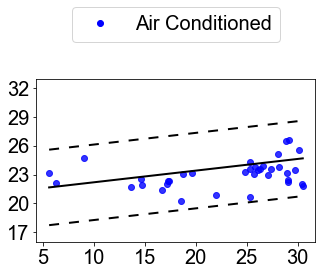

In [315]:
# sort the data points by t_out_combined
t_out = np.array(df_ACM_SET_ac['t_out_combined'])
t_out = t_out[np.argsort(t_out)]
middle_line = slope * t_out + intercept
up_line = slope * t_out + intercept + range/2
low_line = slope * t_out + intercept - range/2

# plot data points
plt.figure(figsize=(5, 3))
sns.regplot(x='t_out_combined', y='temp_n', data=df_ACM_SET_ac, fit_reg=False, scatter_kws={'color': 'blue'})
plt.plot(t_out, middle_line, color='black', linewidth=2)
plt.plot(t_out, up_line, color='black', linewidth=2, linestyle='--', dashes=(5, 5))
plt.plot(t_out, low_line, color='black', linewidth=2, linestyle='--', dashes=(5, 5))

plt.xlabel('', fontsize=20)
plt.ylabel('', fontsize=20)
plt.xticks(np.arange(5, 33, 5), fontsize=20)
plt.yticks(np.arange(17, 33, 3), fontsize=20)
plt.ylim(16, 33)
plt.grid(False)
plt.rcParams['font.family'] = 'Arial'
plt.plot([], [], 'o', color='blue', label='Air Conditioned')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.5), ncol=2, fontsize=20)
plt.savefig('figs/fig_ACM_SET_ac.pdf', format='pdf', bbox_inches='tight')

In [316]:
range

7.868453134432052

In [317]:
# Filter for office buildings with naturally ventilated cooling
df_data_SET_TA_AC = df_data_SET_TA[df_data_SET_TA['cooling_type'] == 'Air Conditioned']
print(f'AC building occupants without missing data:', len(df_data_SET_TA_AC))

# Filter for office buildings with naturally ventilated cooling
df_data_SET_TA_AC_office = df_data_SET_TA_AC[df_data_SET_TA_AC['building_type'] == 'office']
print(f'AC office building occupants without missing data:', len(df_data_SET_TA_AC_office))

AC building occupants without missing data: 4828
AC office building occupants without missing data: 4828


In [318]:
result = 100 * accuracy_individual(slope, intercept, range, df_data_2_AC, 'set')
print('Individual TSV prediction accraucy, AC building: {:.0f} %'.format(result))
result = 100 * accuracy_individual(slope, intercept, range, df_data_2_AC_office, 'set')
print('Individual TSV prediction accraucy, AC office building: {:.0f} %'.format(result))

result = 100 * accuracy_mean(slope, intercept, range, df_bldg_2_AC, 'set')
print('Mean TSV prediction accraucy, AC building: {:.0f} %'.format(result))
result = 100 * accuracy_mean(slope, intercept, range, df_bldg_2_AC_office, 'set')
print('Mean TSV prediction accraucy, AC office building: {:.0f} %'.format(result))

result = 100 * accuracy_accept(slope, intercept, range, df_data_SET_TA_AC, 'set')
print('Individual acceptablility prediction accraucy, NV building: {:.0f} %'.format(result))
result = 100 * accuracy_accept(slope, intercept, range, df_data_SET_TA_AC_office, 'set')
print('Individual acceptablilityprediction accraucy, NV office building: {:.0f} %'.format(result))

Individual TSV prediction accraucy, AC building: 78 %
Individual TSV prediction accraucy, AC office building: 79 %
Mean TSV prediction accraucy, AC building: 74 %
Mean TSV prediction accraucy, AC office building: 74 %
Individual acceptablility prediction accraucy, NV building: 78 %
Individual acceptablilityprediction accraucy, NV office building: 78 %


# Evidence 3

In [280]:
def regression_SET_b(data_bldg):
    """
    set = a * TSV + b
    Regressing Standard Effective Temperature (set) against Thermal Sensation Vote (TSV).
    Use the regression model to derive the neutral temperature by letting TSV equals 0.
    The upper and lower limit of 80% comfort zone are derived by letting TSV equals +-0.85.
    """
    lm_result = smf.ols(formula='set ~ thermal_sensation', data=data_bldg).fit()
    slope = lm_result.params['thermal_sensation']
    intercept = lm_result.params['Intercept']
    # check whether the slope is significant
    if lm_result.pvalues['thermal_sensation'] < 0.05:
        a = slope
        b = intercept
        temp_n = b
        temp_up = 0.85*a + b
        temp_low = (-0.85)*a + b
        sig_model = [slope, intercept, temp_n, temp_up, temp_low]
        return sig_model
    else:
        return [np.nan] * 5

In [281]:
df_bldg_3 = df_bldg.copy()
# Apply the function to each group of df_data_2 grouped by 'building_id'
grouped_results = df_data_2.groupby('building_id').apply(regression_SET_b)
# Convert the grouped results into a DataFrame with appropriate column names
results_df = pd.DataFrame(grouped_results.tolist(), index=grouped_results.index, columns=['slope', 'intercept', 'temp_n', 'temp_up', 'temp_low'])
# Merge the results back into df_bldg_3
df_bldg_3 = df_bldg_3.merge(results_df, left_on='building_id', right_index=True, how='left')

## SET ACM NV using regression Approach (b)

In [282]:
# Get rid of all nan values in the temp_n column
df_bldg_3_sig = df_bldg_3[~df_bldg_3['temp_n'].isna()]
df_bldg_3_sig_NV = df_bldg_3_sig[df_bldg_3_sig['cooling_type'] == 'Naturally Ventilated'].copy()
df_bldg_3_sig_NV_office = df_bldg_3_sig_NV[df_bldg_3_sig_NV['building_type'] == 'office'].copy()
print("NV office buildings with significant models:", len(df_bldg_3_sig_NV_office))

NV office buildings with significant models: 35


In [296]:
# Plot t_out_combined and temp_n data points in df_bldg_3_sig_NV_office
# sns.scatterplot(data=df_bldg_3_sig_NV_office, x='t_out_combined', y='temp_n')
# No outliers
df_ACM_SET_b = df_bldg_3_sig_NV_office

In [319]:
intercept, slope = weighted_reg(df_ACM_SET_b['t_out_combined'], df_ACM_SET_b['temp_n'], df_ACM_SET_b['records'])
# print the fitted line slope and intercept
print("******************************************************************************")
print('ACM regression line slope: {:.2f}'.format(slope))
print('ACM regression line intercept: {:.2f}'.format(intercept))
# calculate the mean range of 80% comfort zone
range = df_ACM_SET_b['temp_up'].mean() - df_ACM_SET_b['temp_low'].mean()
print('ACM 80% comfort zone: {:.2f}'.format(range))

p value: 0.000
MSE: 2.5
RMSE: 1.6
                            WLS Regression Results                            
Dep. Variable:                 temp_n   R-squared:                       0.696
Model:                            WLS   Adj. R-squared:                  0.687
Method:                 Least Squares   F-statistic:                     75.62
Date:                Fri, 01 Mar 2024   Prob (F-statistic):           4.74e-10
Time:                        23:01:14   Log-Likelihood:                -67.261
No. Observations:                  35   AIC:                             138.5
Df Residuals:                      33   BIC:                             141.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const     

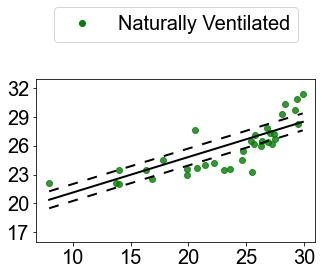

In [320]:
# sort the data points by t_out_combined
t_out = np.array(df_ACM_SET_b['t_out_combined'])
t_out = t_out[np.argsort(t_out)]
middle_line = slope * t_out + intercept
up_line = slope * t_out + intercept + range/2
low_line = slope * t_out + intercept - range/2
# plot data points
plt.figure(figsize=(5, 3))
sns.regplot(x='t_out_combined', y='temp_n', data=df_ACM_SET_b, fit_reg=False, scatter_kws={'color': 'green'})
plt.plot(t_out, middle_line, color='black', linewidth=2)
plt.plot(t_out, up_line, color='black', linewidth=2, linestyle='--', dashes=(5, 5))
plt.plot(t_out, low_line, color='black', linewidth=2, linestyle='--', dashes=(5, 5))

plt.xlabel('', fontsize=20)
plt.ylabel('', fontsize=20)
plt.xticks(np.arange(5, 33, 5), fontsize=20)
plt.yticks(np.arange(17, 33, 3), fontsize=20)
plt.ylim(16, 33)
plt.grid(False)
plt.rcParams['font.family'] = 'Arial'
plt.plot([], [], 'o', color='green', label='Naturally Ventilated')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.5), ncol=2, fontsize=20)
plt.savefig('figs/fig_ACM_SET_b.pdf', format='pdf', bbox_inches='tight')

In [321]:
range

1.7675352616232551

In [322]:
range = 13

In [323]:
result = 100 * accuracy_individual(slope, intercept, range, df_data_2_NV, 'set')
print('Individual TSV prediction accraucy, NV building: {:.0f} %'.format(result))
result = 100 * accuracy_individual(slope, intercept, range, df_data_2_NV_office, 'set')
print('Individual TSV prediction accraucy, NV office building: {:.0f} %'.format(result))

result = 100 * accuracy_mean(slope, intercept, range, df_bldg_2_NV, 'set')
print('Mean TSV prediction accraucy, NV building: {:.0f} %'.format(result))
result = 100 * accuracy_mean(slope, intercept, range, df_bldg_2_NV_office, 'set')
print('Mean TSV prediction accraucy, NV office building: {:.0f} %'.format(result))

result = 100 * accuracy_accept(slope, intercept, range, df_data_SET_TA_NV, 'set')
print('Individual acceptablility prediction accraucy, NV building: {:.0f} %'.format(result))
result = 100 * accuracy_accept(slope, intercept, range, df_data_SET_TA_NV_office, 'set')
print('Individual acceptablilityprediction accraucy, NV office building: {:.0f} %'.format(result))


Individual TSV prediction accraucy, NV building: 74 %
Individual TSV prediction accraucy, NV office building: 76 %
Mean TSV prediction accraucy, NV building: 63 %
Mean TSV prediction accraucy, NV office building: 57 %
Individual acceptablility prediction accraucy, NV building: 78 %
Individual acceptablilityprediction accraucy, NV office building: 73 %


## SET ACM AC using regression Approach (b)

In [324]:
df_bldg_3_sig_AC = df_bldg_3_sig[df_bldg_3_sig['cooling_type'] == 'Air Conditioned'].copy()
df_bldg_3_sig_AC_office = df_bldg_3_sig_AC[df_bldg_3_sig_AC['building_type'] == 'office'].copy()
print("AC office buildings with significant models:", len(df_bldg_3_sig_AC_office))

AC office buildings with significant models: 39


In [325]:
# Plot t_out_combined and temp_n data points in df_bldg_3_sig_AC_office
# sns.scatterplot(data=df_bldg_3_sig_AC_office, x='t_out_combined', y='temp_n')
# Identifiy outliers of temp_n
outliers = df_bldg_3_sig_AC_office[(df_bldg_3_sig_AC_office['t_out_combined'] < 0)]
# remove the outliers
df_ACM_SET_ac_b = df_bldg_3_sig_AC_office.drop(outliers.index)
outliers

,building_id,t_out_combined,top,vel,set,thermal_sensation,records,cooling_type,building_type,database,slope,intercept,temp_n,temp_up,temp_low
127,128,-18.572604,22.135000,0.063500,23.397436,-0.500000,40,Air Conditioned,office,1.0,-0.495929,23.168546,23.168546,22.747006,23.590085
132,133,-26.098344,23.197436,0.075385,24.089189,0.128205,39,Air Conditioned,office,1.0,-0.451139,24.174540,24.174540,23.791071,24.558008


In [326]:
intercept, slope = weighted_reg(df_ACM_SET_ac_b['t_out_combined'], df_ACM_SET_ac_b['temp_n'], df_ACM_SET_ac_b['records'])
# print the fitted line slope and intercept
print("******************************************************************************")
print('ACM regression line slope: {:.2f}'.format(slope))
print('ACM regression line intercept: {:.2f}'.format(intercept))
# calculate the mean range of 80% comfort zone
range = df_ACM_SET_ac_b['temp_up'].mean() - df_ACM_SET_ac_b['temp_low'].mean()
print('ACM 80% comfort zone: {:.2f}'.format(range))

p value: 0.059
MSE: 0.9
RMSE: 0.9
                            WLS Regression Results                            
Dep. Variable:                 temp_n   R-squared:                       0.098
Model:                            WLS   Adj. R-squared:                  0.072
Method:                 Least Squares   F-statistic:                     3.801
Date:                Fri, 01 Mar 2024   Prob (F-statistic):             0.0593
Time:                        23:01:21   Log-Likelihood:                -49.958
No. Observations:                  37   AIC:                             103.9
Df Residuals:                      35   BIC:                             107.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const     

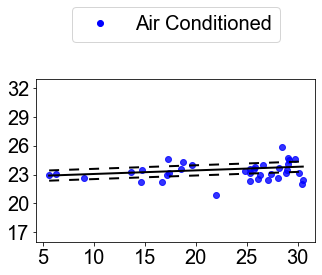

In [327]:
# sort the data points by t_out_combined
t_out = np.array(df_ACM_SET_ac_b['t_out_combined'])
t_out = t_out[np.argsort(t_out)]
middle_line = slope * t_out + intercept
up_line = slope * t_out + intercept + range/2
low_line = slope * t_out + intercept - range/2
# plot data points
plt.figure(figsize=(5, 3))
sns.regplot(x='t_out_combined', y='temp_n', data=df_ACM_SET_ac_b, fit_reg=False, scatter_kws={'color': 'blue'})
plt.plot(t_out, middle_line, color='black', linewidth=2)
plt.plot(t_out, up_line, color='black', linewidth=2, linestyle='--', dashes=(5, 5))
plt.plot(t_out, low_line, color='black', linewidth=2, linestyle='--', dashes=(5, 5))
plt.xlabel('', fontsize=20)
plt.ylabel('', fontsize=20)
plt.xticks(np.arange(5, 33, 5), fontsize=20)
plt.yticks(np.arange(17, 33, 3), fontsize=20)
plt.ylim(16, 33)
plt.grid(False)
plt.rcParams['font.family'] = 'Arial'
plt.plot([], [], 'o', color='blue', label='Air Conditioned')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.5), ncol=2, fontsize=20)
plt.savefig('figs/fig_ACM_SET_ac_b.pdf', format='pdf', bbox_inches='tight')

In [328]:
range

1.0663178157479116

In [329]:
range = 8

In [330]:
result = 100 * accuracy_individual(slope, intercept, range, df_data_2_AC, 'set')
print('All TSV prediction accraucy, AC building: {:.0f} %'.format(result))
result = 100 * accuracy_individual(slope, intercept, range, df_data_2_AC_office, 'set')
print('All TSV prediction accraucy, AC office building: {:.0f} %'.format(result))

result = 100 * accuracy_mean(slope, intercept, range, df_bldg_2_AC, 'set')
print('Mean TSV prediction accraucy, AC building: {:.0f} %'.format(result))
result = 100 * accuracy_mean(slope, intercept, range, df_bldg_2_AC_office, 'set')
print('Mean TSV prediction accraucy, AC office building: {:.0f} %'.format(result))

result = 100 * accuracy_accept(slope, intercept, range, df_data_SET_TA_AC, 'set')
print('Individual acceptablility prediction accraucy, AC building: {:.0f} %'.format(result))
result = 100 * accuracy_accept(slope, intercept, range, df_data_SET_TA_AC_office, 'set')
print('Individual acceptablilityprediction accraucy, AC office building: {:.0f} %'.format(result))

All TSV prediction accraucy, AC building: 81 %
All TSV prediction accraucy, AC office building: 81 %
Mean TSV prediction accraucy, AC building: 80 %
Mean TSV prediction accraucy, AC office building: 80 %
Individual acceptablility prediction accraucy, AC building: 82 %
Individual acceptablilityprediction accraucy, AC office building: 82 %


# Try nudging paper Fig 6

<AxesSubplot:xlabel='set', ylabel='temp_n'>

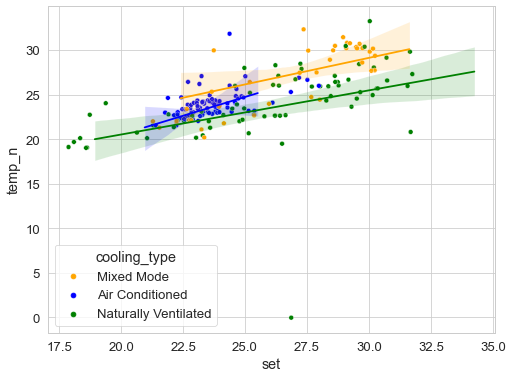

In [114]:
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.5)
fig, ax = plt.subplots(figsize=(8, 6))
ax = sns.scatterplot(x="top", y="temp_n", hue="cooling_type", data=df_bldg_1_sig, palette=['orange', 'blue', 'green'], legend=True)
# plot three regression lines by cooling_type
sns.regplot(x='set', y='temp_n', data=df_bldg_2_sig[df_bldg_2_sig['cooling_type'] == 'Naturally Ventilated'], scatter=False, line_kws={'color': 'green'})
sns.regplot(x='set', y='temp_n', data=df_bldg_2_sig[df_bldg_2_sig['cooling_type'] == 'Air Conditioned'], scatter=False, line_kws={'color': 'blue'})
sns.regplot(x='set', y='temp_n', data=df_bldg_2_sig[df_bldg_2_sig['cooling_type'] == 'Mixed Mode'], scatter=False, line_kws={'color': 'orange'})

<AxesSubplot:xlabel='set', ylabel='temp_n'>

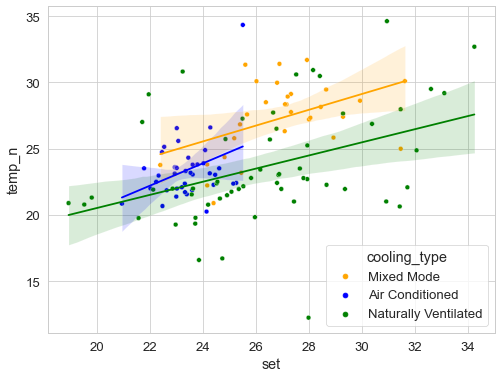

In [112]:
# remove the row when temp_n is larger than 50 in df_bldg_2_sig
df_bldg_2_sig = df_bldg_2_sig[df_bldg_2_sig['temp_n'] < 50]
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.5)
fig, ax = plt.subplots(figsize=(8, 6))
ax = sns.scatterplot(x="set", y="temp_n", hue="cooling_type", data=df_bldg_2_sig, palette=['orange', 'blue', 'green'], legend=True)

<AxesSubplot:xlabel='set', ylabel='temp_n'>

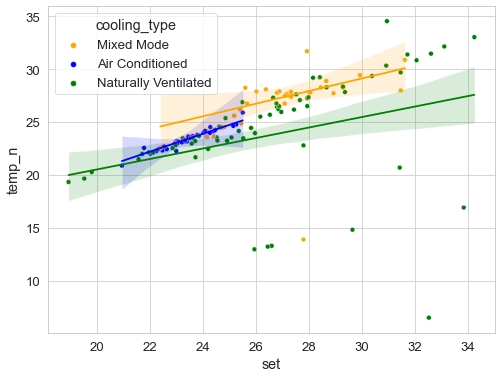

In [113]:
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.5)
fig, ax = plt.subplots(figsize=(8, 6))
ax = sns.scatterplot(x="set", y="temp_n", hue="cooling_type", data=df_bldg_3_sig, palette=['orange', 'blue', 'green'], legend=True)